# DNF repoquery run via subprocess

In [1]:
import networkx as nx
import subprocess as sp
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import time

In [2]:
def pkgname(name):
    return name.rsplit("-", 2)[0]

In [3]:
def SRPM_provides(SRPM):
    cmd = "dnf repoquery --repo=rawhide-source --provides"
    SRPM = SRPM if SRPM.endswith(".src") else SRPM + ".src"
    result = sp.check_output(cmd.split() + [SRPM], universal_newlines=True)
    result = [line.split()[0] for line in result.splitlines()]
    return set(result)

In [4]:
def SRPM_requires(SRPM):
    cmd = "dnf repoquery --repo=rawhide,rawhide-source --requires --resolve"
    SRPM = SRPM if SRPM.endswith(".src") else SRPM + ".src"
    result = sp.check_output(cmd.split() + [SRPM], universal_newlines=True)
    result = [pkgname(line) for line in result.splitlines()]
    return set(result)

In [5]:
def RPM_requires(RPM):
    cmd = "dnf repoquery --repo=rawhide --requires --resolve"
    result = sp.check_output(cmd.split() + [RPM], universal_newlines=True)
    result = [pkgname(line.split()[0]) for line in result.splitlines()]
    return set(result)

In [6]:
def SRPMs_for_RPMs(RPMs):
    cmd = "dnf repoquery --repo=rawhide --source"
    result = sp.check_output(cmd.split() + list(RPMs), universal_newlines=True)
    result = [pkgname(line) for line in result.splitlines() if not line.startswith("(none)")]
    return set(result)

In [7]:
def is_SRPM(PKG):
    cmd = "dnf repoquery --repo=rawhide --source"
    result = sp.check_output(cmd.split() + [PKG], universal_newlines=True)
    try:
        result = pkgname(result.splitlines()[-1])
    except IndexError:
        return True
    return result == PKG

In [8]:
is_SRPM("bash")

Last metadata expiration check: 0:36:52 ago on Fri 24 May 2024 12:13:14 PM CEST.


True

In [9]:
is_SRPM("python3-colorama")

Last metadata expiration check: 0:36:53 ago on Fri 24 May 2024 12:13:14 PM CEST.


False

In [10]:
is_SRPM("python-colorama")

Last metadata expiration check: 0:36:54 ago on Fri 24 May 2024 12:13:14 PM CEST.


True

In [11]:
SRPM_requires("python3.12")

Last metadata expiration check: 0:33:58 ago on Fri 24 May 2024 12:16:11 PM CEST.


{'autoconf',
 'bluez-libs-devel',
 'bzip2',
 'bzip2-devel',
 'desktop-file-utils',
 'expat-devel',
 'findutils',
 'gcc-c++',
 'gdb',
 'gdbm-devel',
 'git-core',
 'glibc-all-langpacks',
 'glibc-devel',
 'gmp-devel',
 'gnupg2',
 'libX11-devel',
 'libappstream-glib',
 'libb2-devel',
 'libffi-devel',
 'libnsl2-devel',
 'libtirpc-devel',
 'libuuid-devel',
 'make',
 'mesa-libGL-devel',
 'mpdecimal-devel',
 'ncurses-devel',
 'net-tools',
 'openssl-devel',
 'pkgconf-pkg-config',
 'python-pip-wheel',
 'python-rpm-macros',
 'python-setuptools-wheel',
 'python-wheel-wheel',
 'python3',
 'python3-rpm-generators',
 'readline-devel',
 'redhat-rpm-config',
 'sqlite-devel',
 'systemtap-sdt-devel',
 'tar',
 'tcl-devel',
 'tix-devel',
 'tk-devel',
 'tzdata',
 'valgrind-devel',
 'xz-devel',
 'zlib-ng-compat-devel'}

In [12]:
SRPMs_for_RPMs(["python3-debug", "python3", "bash", "glibc"])

Last metadata expiration check: 0:36:55 ago on Fri 24 May 2024 12:13:14 PM CEST.


{'bash', 'glibc', 'python3.12'}

In [13]:
RPM_requires("python3")

Last metadata expiration check: 0:36:56 ago on Fri 24 May 2024 12:13:14 PM CEST.


{'glibc', 'python3-libs'}

In [14]:
SRPM_provides("python3.12")

Last metadata expiration check: 0:34:00 ago on Fri 24 May 2024 12:16:11 PM CEST.


{'python-unversioned-command',
 'python3',
 'python3-debug',
 'python3-devel',
 'python3-idle',
 'python3-libs',
 'python3-test',
 'python3-tkinter',
 'python3.12-debuginfo',
 'python3.12-debugsource'}

In [15]:
def create_graph(pkg, depth=1):
    start = time.time()
    SRPM_done, RPM_done = set(), set()

    G = nx.MultiDiGraph()
    
    if is_SRPM(pkg):
        RPM_queue = set()
        SRPM_queue = {pkg}
    else:
        RPM_queue = {pkg}
        SRPM_queue = SRPMs_for_RPMs([pkg])

    for round in range(depth):
        RPM_queue_next, SRPM_queue_next = set(), set()

        while len(SRPM_queue):
            SRPM = SRPM_queue.pop()
            SRPM_done.add(SRPM)
            print(f"SRPM - {SRPM}")
            rpms = SRPM_provides(SRPM)
            for rpm in rpms:
                print(f"{SRPM} provides {rpm}")
                G.add_edge(SRPM, rpm, color="blue")
            RPM_queue_next |= (rpms - RPM_done)
            rpms = SRPM_requires(SRPM)
            for rpm in rpms:
                print(f"{SRPM} BUILD requires {rpm}")
                G.add_edge(rpm, SRPM, color="green")
            RPM_queue_next |= (rpms - RPM_done)

        while len(RPM_queue):
            RPM = RPM_queue.pop()
            RPM_done.add(RPM)
            print(f"RPM - {RPM}")
            rpms = RPM_requires(RPM)
            for rpm in rpms:
                print(f"{RPM} requires {rpm}")
                G.add_edge(rpm, RPM, color="red")            
            RPM_queue_next |= (rpms - RPM_done)
            srpms = SRPMs_for_RPMs(rpms)
            SRPM_queue_next |= (srpms - SRPM_done)

        RPM_queue, SRPM_queue = RPM_queue_next, SRPM_queue_next

    print(f"Graph depth {depth} with {len(G.nodes)} nodes and {len(G.edges)} edges")
    end = time.time()
    print(f"Total seconds: {end - start}")
    return G

In [16]:
def draw_graph(g):
    fig = plt.figure(1, figsize=(30, 30))
    edge_colors = nx.get_edge_attributes(g,'color').values()
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, alpha=0)
    nx.draw_networkx_labels(g, pos, bbox=dict(fc="b", alpha=0.2))
    nx.draw_networkx_edges(g, pos, edge_color=edge_colors)
    plt.show()

In [17]:
g = create_graph("python-colorama")

Last metadata expiration check: 0:36:58 ago on Fri 24 May 2024 12:13:14 PM CEST.


SRPM - python-colorama


Last metadata expiration check: 0:34:01 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama provides python3-colorama
python-colorama BUILD requires python3-packaging
python-colorama BUILD requires python3-devel
python-colorama BUILD requires python3-hatchling
python-colorama BUILD requires python3-tomli
python-colorama BUILD requires python3-pytest
python-colorama BUILD requires python3-pip
python-colorama BUILD requires pyproject-rpm-macros
Graph depth 1 with 9 nodes and 8 edges
Total seconds: 2.108215093612671


Last metadata expiration check: 0:34:02 ago on Fri 24 May 2024 12:16:11 PM CEST.


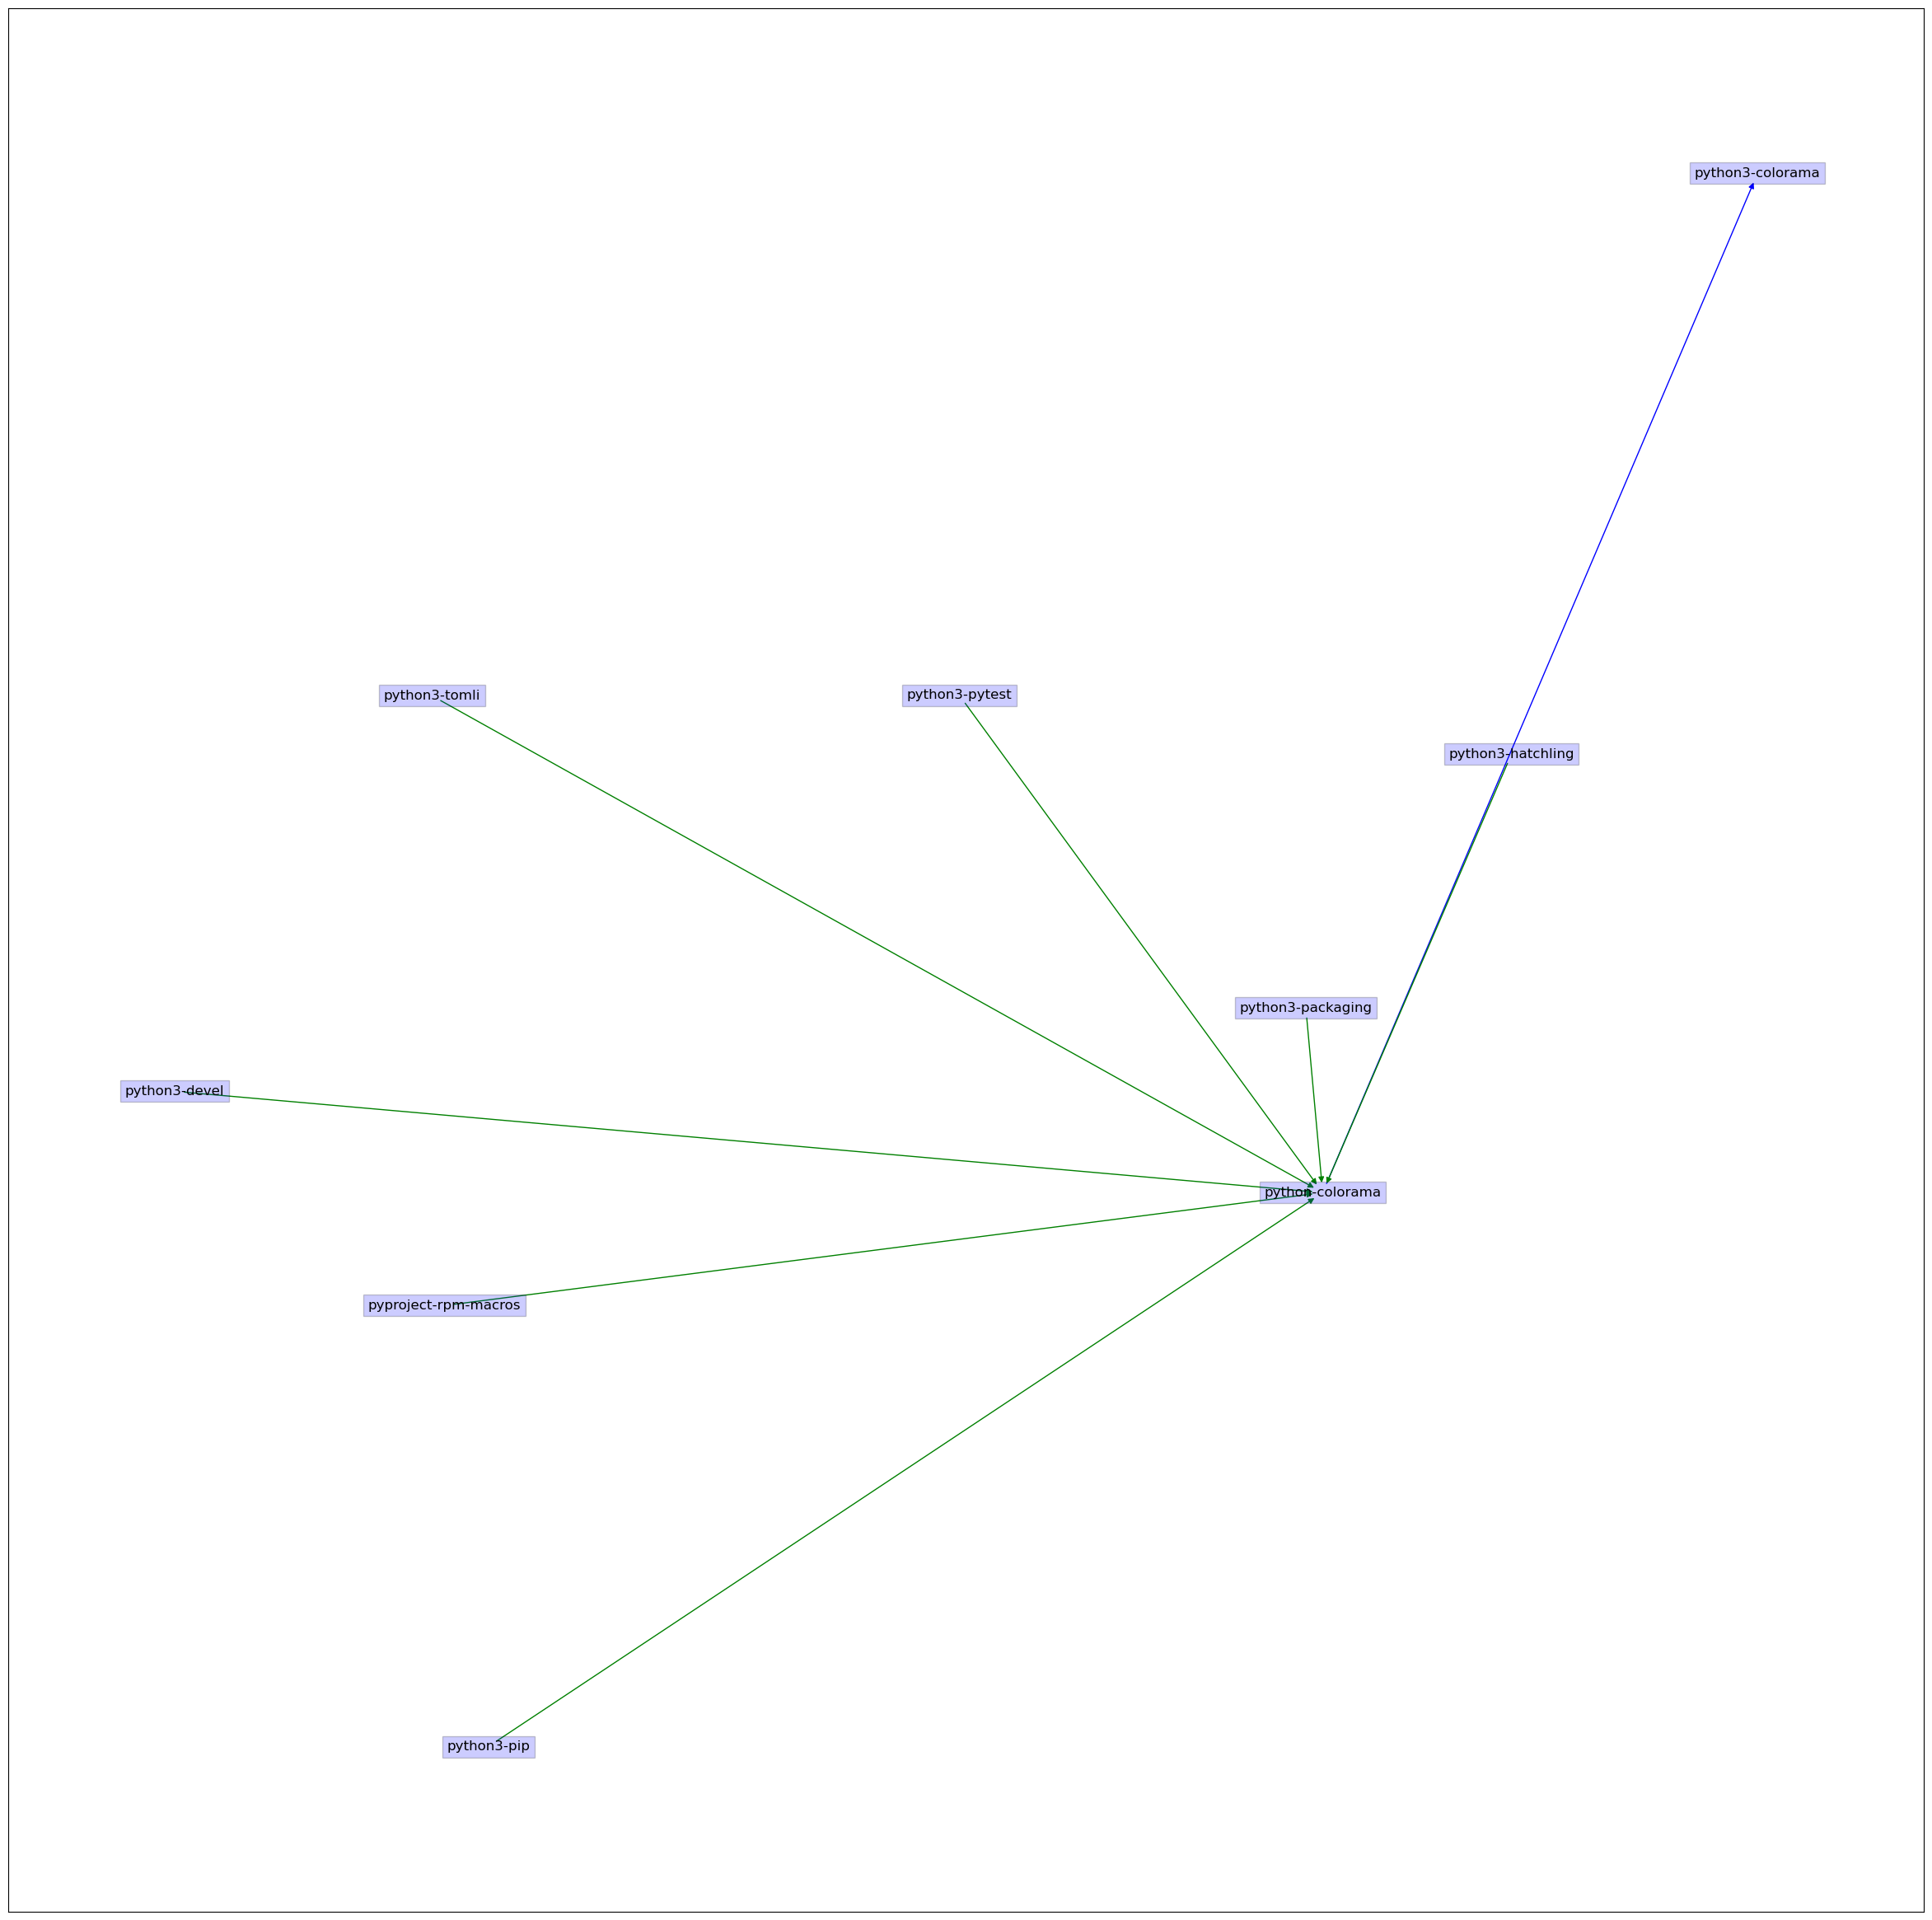

In [18]:
draw_graph(g)

In [19]:
g = create_graph("python3-colorama")

Last metadata expiration check: 0:37:00 ago on Fri 24 May 2024 12:13:14 PM CEST.
Last metadata expiration check: 0:37:01 ago on Fri 24 May 2024 12:13:14 PM CEST.


SRPM - python-colorama


Last metadata expiration check: 0:34:04 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama provides python3-colorama


Last metadata expiration check: 0:34:05 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama BUILD requires python3-packaging
python-colorama BUILD requires python3-devel
python-colorama BUILD requires python3-hatchling
python-colorama BUILD requires python3-tomli
python-colorama BUILD requires python3-pytest
python-colorama BUILD requires python3-pip
python-colorama BUILD requires pyproject-rpm-macros
RPM - python3-colorama


Last metadata expiration check: 0:37:03 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-colorama requires python3
Graph depth 1 with 10 nodes and 9 edges
Total seconds: 4.26181960105896


Last metadata expiration check: 0:37:03 ago on Fri 24 May 2024 12:13:14 PM CEST.


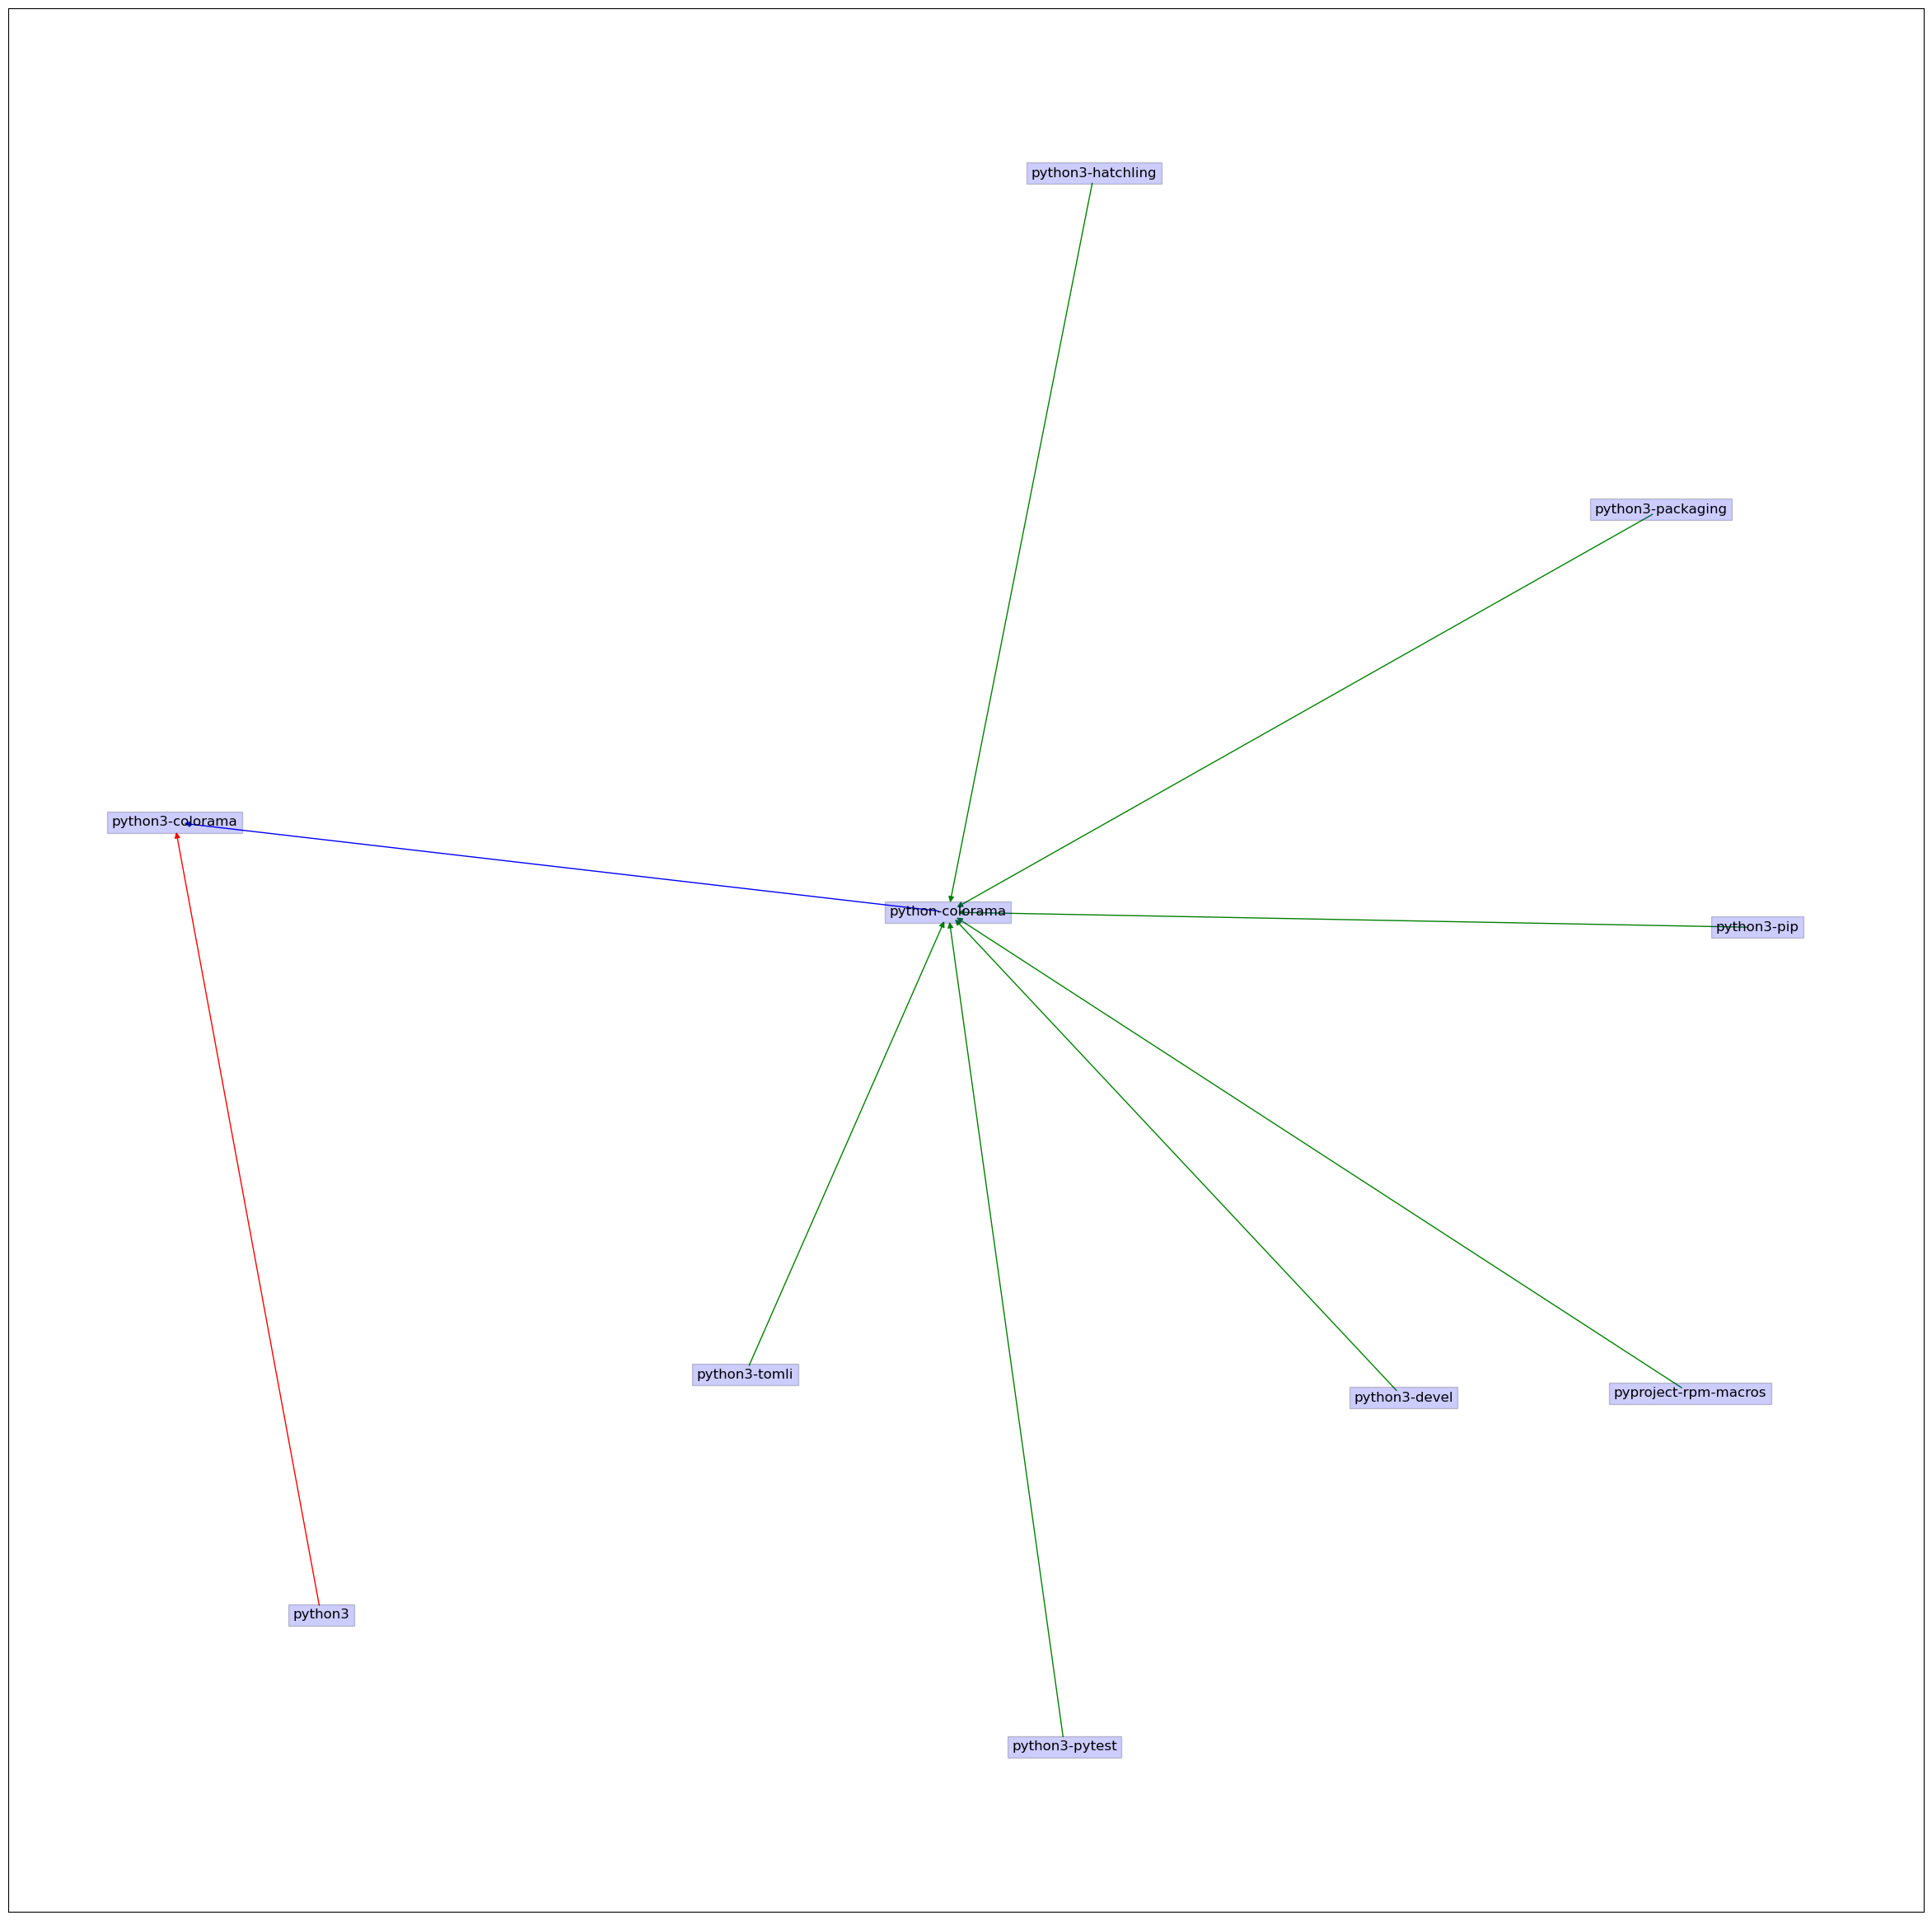

In [20]:
draw_graph(g)

In [21]:
g = create_graph("python-colorama", depth=2)

Last metadata expiration check: 0:37:04 ago on Fri 24 May 2024 12:13:14 PM CEST.


SRPM - python-colorama


Last metadata expiration check: 0:34:08 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama provides python3-colorama


Last metadata expiration check: 0:34:09 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama BUILD requires python3-packaging
python-colorama BUILD requires python3-devel
python-colorama BUILD requires python3-hatchling
python-colorama BUILD requires python3-tomli
python-colorama BUILD requires python3-pytest
python-colorama BUILD requires python3-pip
python-colorama BUILD requires pyproject-rpm-macros
RPM - python3-colorama


Last metadata expiration check: 0:37:06 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-colorama requires python3


Last metadata expiration check: 0:37:07 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-packaging


Last metadata expiration check: 0:37:08 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-packaging requires python3


Last metadata expiration check: 0:37:09 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-devel


Last metadata expiration check: 0:37:09 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-devel requires python-rpm-macros
python3-devel requires pkgconf-pkg-config
python3-devel requires python3-libs
python3-devel requires python3-rpm-macros
python3-devel requires python3
python3-devel requires python3-rpm-generators
python3-devel requires bash
python3-devel requires pyproject-rpm-macros


Last metadata expiration check: 0:37:10 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-hatchling


Last metadata expiration check: 0:37:11 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-hatchling requires python3-packaging
python3-hatchling requires python3-pluggy
python3-hatchling requires python3
python3-hatchling requires python3-pathspec
python3-hatchling requires python3-trove-classifiers
python3-hatchling requires python3-editables


Last metadata expiration check: 0:37:12 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-tomli


Last metadata expiration check: 0:37:12 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-tomli requires python3


Last metadata expiration check: 0:37:13 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pytest


Last metadata expiration check: 0:37:14 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pytest requires python3
python3-pytest requires python3-packaging
python3-pytest requires python3-iniconfig
python3-pytest requires python3-pluggy


Last metadata expiration check: 0:37:15 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pip


Last metadata expiration check: 0:37:15 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pip requires python3
python3-pip requires ca-certificates


Last metadata expiration check: 0:37:16 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - pyproject-rpm-macros


Last metadata expiration check: 0:37:17 ago on Fri 24 May 2024 12:13:14 PM CEST.


pyproject-rpm-macros requires python-rpm-macros
pyproject-rpm-macros requires findutils
pyproject-rpm-macros requires python3-rpm-macros
pyproject-rpm-macros requires rpm-build
pyproject-rpm-macros requires sed
pyproject-rpm-macros requires python-srpm-macros
pyproject-rpm-macros requires pyproject-srpm-macros
Graph depth 2 with 27 nodes and 38 edges
Total seconds: 13.857860803604126


Last metadata expiration check: 0:37:18 ago on Fri 24 May 2024 12:13:14 PM CEST.


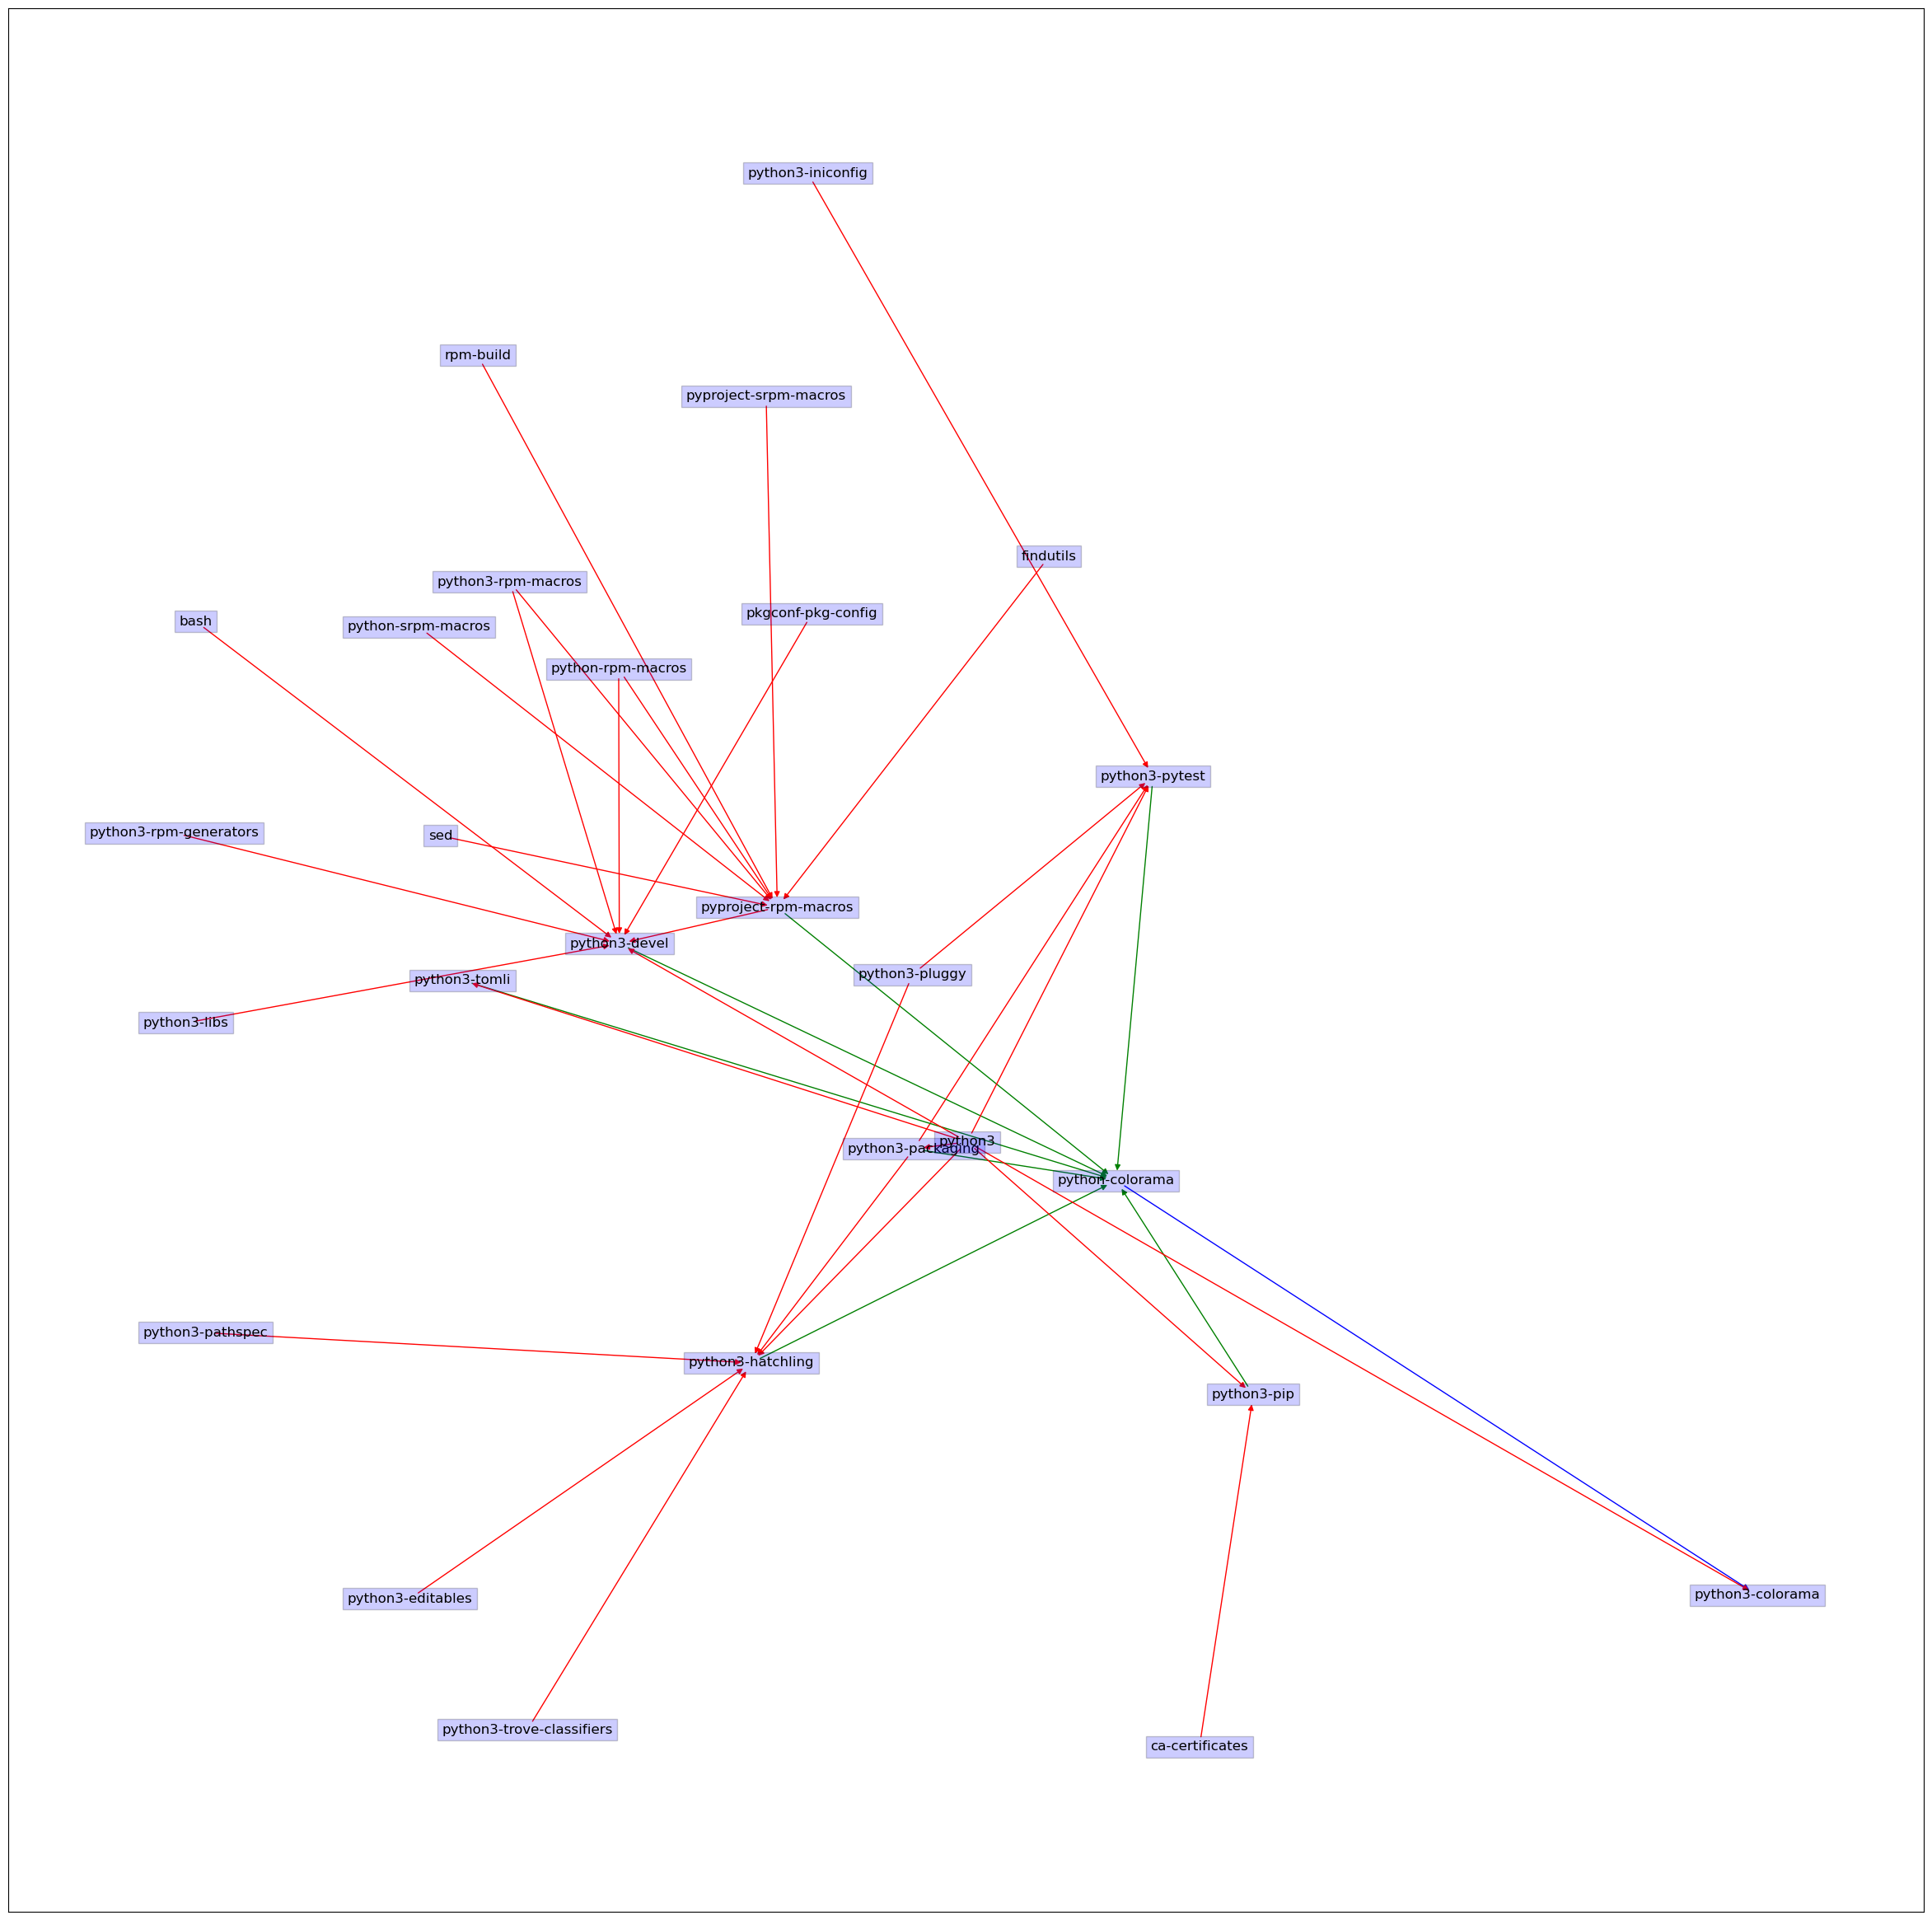

In [22]:
draw_graph(g)

In [23]:
g = create_graph("python-colorama", depth=3)

Last metadata expiration check: 0:37:19 ago on Fri 24 May 2024 12:13:14 PM CEST.


SRPM - python-colorama


Last metadata expiration check: 0:34:22 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama provides python3-colorama


Last metadata expiration check: 0:34:23 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-colorama BUILD requires python3-packaging
python-colorama BUILD requires python3-devel
python-colorama BUILD requires python3-hatchling
python-colorama BUILD requires python3-tomli
python-colorama BUILD requires python3-pytest
python-colorama BUILD requires python3-pip
python-colorama BUILD requires pyproject-rpm-macros
RPM - python3-colorama


Last metadata expiration check: 0:37:21 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-colorama requires python3


Last metadata expiration check: 0:37:21 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-packaging


Last metadata expiration check: 0:37:22 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-packaging requires python3


Last metadata expiration check: 0:37:23 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-devel


Last metadata expiration check: 0:37:24 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-devel requires python-rpm-macros
python3-devel requires pkgconf-pkg-config
python3-devel requires python3-libs
python3-devel requires python3-rpm-macros
python3-devel requires python3
python3-devel requires python3-rpm-generators
python3-devel requires bash
python3-devel requires pyproject-rpm-macros


Last metadata expiration check: 0:37:24 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-hatchling


Last metadata expiration check: 0:37:25 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-hatchling requires python3-packaging
python3-hatchling requires python3-pluggy
python3-hatchling requires python3
python3-hatchling requires python3-pathspec
python3-hatchling requires python3-trove-classifiers
python3-hatchling requires python3-editables


Last metadata expiration check: 0:37:26 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-tomli


Last metadata expiration check: 0:37:27 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-tomli requires python3


Last metadata expiration check: 0:37:28 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pytest


Last metadata expiration check: 0:37:29 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pytest requires python3
python3-pytest requires python3-packaging
python3-pytest requires python3-iniconfig
python3-pytest requires python3-pluggy


Last metadata expiration check: 0:37:29 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pip


Last metadata expiration check: 0:37:30 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pip requires python3
python3-pip requires ca-certificates


Last metadata expiration check: 0:37:31 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - pyproject-rpm-macros


Last metadata expiration check: 0:37:32 ago on Fri 24 May 2024 12:13:14 PM CEST.


pyproject-rpm-macros requires python-rpm-macros
pyproject-rpm-macros requires findutils
pyproject-rpm-macros requires python3-rpm-macros
pyproject-rpm-macros requires rpm-build
pyproject-rpm-macros requires sed
pyproject-rpm-macros requires python-srpm-macros
pyproject-rpm-macros requires pyproject-srpm-macros


Last metadata expiration check: 0:37:33 ago on Fri 24 May 2024 12:13:14 PM CEST.


SRPM - python-rpm-macros


Last metadata expiration check: 0:34:36 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-rpm-macros provides python3-rpm-macros
python-rpm-macros provides python-rpm-macros
python-rpm-macros provides python-srpm-macros


Last metadata expiration check: 0:34:37 ago on Fri 24 May 2024 12:16:11 PM CEST.


SRPM - python-pathspec


Last metadata expiration check: 0:34:38 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-pathspec provides python3-pathspec


Last metadata expiration check: 0:34:39 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-pathspec BUILD requires python3-flit-core
python-pathspec BUILD requires python3-packaging
python-pathspec BUILD requires python3-devel
python-pathspec BUILD requires python3-tomli
python-pathspec BUILD requires python3-pytest
python-pathspec BUILD requires python3-pip
python-pathspec BUILD requires pyproject-rpm-macros
SRPM - python-rpm-generators


Last metadata expiration check: 0:34:40 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-rpm-generators provides python3-rpm-generators


Last metadata expiration check: 0:34:41 ago on Fri 24 May 2024 12:16:11 PM CEST.


SRPM - python-pluggy


Last metadata expiration check: 0:34:42 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-pluggy provides python3-pluggy


Last metadata expiration check: 0:34:43 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-pluggy BUILD requires python3-packaging
python-pluggy BUILD requires python3-devel
python-pluggy BUILD requires python3-tomli
python-pluggy BUILD requires python3-setuptools_scm+toml
python-pluggy BUILD requires python3-pytest
python-pluggy BUILD requires python3-setuptools
python-pluggy BUILD requires python3-pip
python-pluggy BUILD requires python3-setuptools_scm
python-pluggy BUILD requires python3-wheel
python-pluggy BUILD requires pyproject-rpm-macros
SRPM - findutils


Last metadata expiration check: 0:34:44 ago on Fri 24 May 2024 12:16:11 PM CEST.


findutils provides findutils
findutils provides findutils-debuginfo
findutils provides findutils-debugsource


Last metadata expiration check: 0:34:46 ago on Fri 24 May 2024 12:16:11 PM CEST.


findutils BUILD requires git
findutils BUILD requires libselinux-devel
findutils BUILD requires make
findutils BUILD requires dejagnu
findutils BUILD requires texinfo
findutils BUILD requires gettext-devel
findutils BUILD requires automake
findutils BUILD requires gcc
SRPM - python-trove-classifiers


Last metadata expiration check: 0:34:47 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-trove-classifiers provides python3-trove-classifiers


Last metadata expiration check: 0:34:48 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-trove-classifiers BUILD requires python3-packaging
python-trove-classifiers BUILD requires python3-devel
python-trove-classifiers BUILD requires python3-tomli
python-trove-classifiers BUILD requires python3-pytest
python-trove-classifiers BUILD requires python3-setuptools
python-trove-classifiers BUILD requires python3-pip
python-trove-classifiers BUILD requires python3-wheel
python-trove-classifiers BUILD requires pyproject-rpm-macros
SRPM - python-packaging


Last metadata expiration check: 0:34:49 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-packaging provides python3-packaging
python-packaging provides python-packaging-doc


Last metadata expiration check: 0:34:50 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-packaging BUILD requires python3-flit-core
python-packaging BUILD requires python3-packaging
python-packaging BUILD requires python3-devel
python-packaging BUILD requires python3-tomli
python-packaging BUILD requires python3-pretend
python-packaging BUILD requires python3-pytest
python-packaging BUILD requires python3-pip
python-packaging BUILD requires python3-furo
python-packaging BUILD requires unzip
python-packaging BUILD requires python3-sphinx
python-packaging BUILD requires pyproject-rpm-macros
SRPM - ca-certificates


Last metadata expiration check: 0:34:50 ago on Fri 24 May 2024 12:16:11 PM CEST.


ca-certificates provides ca-certificates


Last metadata expiration check: 0:34:51 ago on Fri 24 May 2024 12:16:11 PM CEST.


ca-certificates BUILD requires perl-interpreter
ca-certificates BUILD requires xmlto
ca-certificates BUILD requires openssl
ca-certificates BUILD requires asciidoc
ca-certificates BUILD requires python3
SRPM - python-editables


Last metadata expiration check: 0:34:52 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-editables provides python3-editables


Last metadata expiration check: 0:34:53 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-editables BUILD requires python3-flit-core
python-editables BUILD requires python3-packaging
python-editables BUILD requires python3-devel
python-editables BUILD requires python3-tomli
python-editables BUILD requires python3-pytest
python-editables BUILD requires python3-pip
python-editables BUILD requires pyproject-rpm-macros
SRPM - python3.12


Last metadata expiration check: 0:34:54 ago on Fri 24 May 2024 12:16:11 PM CEST.


python3.12 provides python-unversioned-command
python3.12 provides python3-devel
python3.12 provides python3-libs
python3.12 provides python3.12-debugsource
python3.12 provides python3
python3.12 provides python3-tkinter
python3.12 provides python3-test
python3.12 provides python3.12-debuginfo
python3.12 provides python3-debug
python3.12 provides python3-idle


Last metadata expiration check: 0:34:55 ago on Fri 24 May 2024 12:16:11 PM CEST.


python3.12 BUILD requires pkgconf-pkg-config
python3.12 BUILD requires libuuid-devel
python3.12 BUILD requires sqlite-devel
python3.12 BUILD requires python-setuptools-wheel
python3.12 BUILD requires gnupg2
python3.12 BUILD requires python3
python3.12 BUILD requires redhat-rpm-config
python3.12 BUILD requires tzdata
python3.12 BUILD requires desktop-file-utils
python3.12 BUILD requires python-rpm-macros
python3.12 BUILD requires net-tools
python3.12 BUILD requires ncurses-devel
python3.12 BUILD requires readline-devel
python3.12 BUILD requires tix-devel
python3.12 BUILD requires openssl-devel
python3.12 BUILD requires gcc-c++
python3.12 BUILD requires mpdecimal-devel
python3.12 BUILD requires tar
python3.12 BUILD requires bzip2
python3.12 BUILD requires tk-devel
python3.12 BUILD requires glibc-all-langpacks
python3.12 BUILD requires autoconf
python3.12 BUILD requires python-pip-wheel
python3.12 BUILD requires expat-devel
python3.12 BUILD requires findutils
python3.12 BUILD requires pyt

Last metadata expiration check: 0:34:56 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-iniconfig provides python3-iniconfig


Last metadata expiration check: 0:34:57 ago on Fri 24 May 2024 12:16:11 PM CEST.


python-iniconfig BUILD requires python3-packaging
python-iniconfig BUILD requires python3-devel
python-iniconfig BUILD requires python3-tomli
python-iniconfig BUILD requires python3-pytest
python-iniconfig BUILD requires python3-setuptools
python-iniconfig BUILD requires python3-pip
python-iniconfig BUILD requires python3-setuptools_scm
python-iniconfig BUILD requires python3-wheel
python-iniconfig BUILD requires pyproject-rpm-macros
SRPM - rpm


Last metadata expiration check: 0:34:58 ago on Fri 24 May 2024 12:16:11 PM CEST.


rpm provides rpm-debugsource
rpm provides python3-rpm
rpm provides rpm-devel
rpm provides rpm-build
rpm provides rpm-plugin-fapolicyd
rpm provides rpm-sign-libs
rpm provides rpm-plugin-selinux
rpm provides rpm-plugin-prioreset
rpm provides rpm-plugin-syslog
rpm provides rpm-plugin-systemd-inhibit
rpm provides rpm-apidocs
rpm provides rpm-plugin-dbus-announce
rpm provides rpm-sign
rpm provides rpm-debuginfo
rpm provides rpm-plugin-fsverity
rpm provides rpm-plugin-ima
rpm provides rpm-build-libs
rpm provides rpm-cron
rpm provides rpm-plugin-audit
rpm provides rpm
rpm provides rpm-libs


Last metadata expiration check: 0:34:59 ago on Fri 24 May 2024 12:16:11 PM CEST.


rpm BUILD requires rpm-sequoia-devel
rpm BUILD requires libzstd-devel
rpm BUILD requires sqlite-devel
rpm BUILD requires redhat-rpm-config
rpm BUILD requires cmake
rpm BUILD requires automake
rpm BUILD requires elfutils-devel
rpm BUILD requires systemd-rpm-macros
rpm BUILD requires libselinux-devel
rpm BUILD requires ncurses-devel
rpm BUILD requires libtool
rpm BUILD requires readline-devel
rpm BUILD requires libarchive-devel
rpm BUILD requires fsverity-utils-devel
rpm BUILD requires gcc
rpm BUILD requires elfutils-libelf-devel
rpm BUILD requires python3-devel
rpm BUILD requires gawk
rpm BUILD requires dbus-devel
rpm BUILD requires gettext-devel
rpm BUILD requires audit-libs-devel
rpm BUILD requires libacl-devel
rpm BUILD requires file-devel
rpm BUILD requires lua-devel
rpm BUILD requires bzip2-devel
rpm BUILD requires libcap-devel
rpm BUILD requires make
rpm BUILD requires xz-devel
rpm BUILD requires ima-evm-utils-devel
rpm BUILD requires zlib-ng-compat-devel
rpm BUILD requires popt-d

Last metadata expiration check: 0:35:00 ago on Fri 24 May 2024 12:16:11 PM CEST.


sed provides sed-debugsource
sed provides sed-debuginfo
sed provides sed


Last metadata expiration check: 0:35:01 ago on Fri 24 May 2024 12:16:11 PM CEST.


sed BUILD requires autoconf
sed BUILD requires libselinux-devel
sed BUILD requires make
sed BUILD requires glibc-devel
sed BUILD requires glibc-langpack-ru
sed BUILD requires perl-Getopt-Long
sed BUILD requires glibc-langpack-en
sed BUILD requires valgrind
sed BUILD requires perl-FileHandle
sed BUILD requires libacl-devel
sed BUILD requires automake
sed BUILD requires gcc
sed BUILD requires glibc-langpack-el
SRPM - bash


Last metadata expiration check: 0:35:02 ago on Fri 24 May 2024 12:16:11 PM CEST.


bash provides bash-doc
bash provides bash-debuginfo
bash provides bash-devel
bash provides bash
bash provides bash-debugsource


Last metadata expiration check: 0:35:02 ago on Fri 24 May 2024 12:16:11 PM CEST.


bash BUILD requires autoconf
bash BUILD requires make
bash BUILD requires gettext
bash BUILD requires ncurses-devel
bash BUILD requires bison
bash BUILD requires texinfo
bash BUILD requires gnupg2
bash BUILD requires audit-libs-devel
bash BUILD requires gcc
bash BUILD requires glibc-all-langpacks
SRPM - pkgconf


Last metadata expiration check: 0:35:03 ago on Fri 24 May 2024 12:16:11 PM CEST.


pkgconf provides pkgconf-pkg-config
pkgconf provides pkgconf-m4
pkgconf provides libpkgconf-devel
pkgconf provides pkgconf-debugsource
pkgconf provides pkgconf-debuginfo
pkgconf provides bomtool
pkgconf provides libpkgconf
pkgconf provides pkgconf


Last metadata expiration check: 0:35:04 ago on Fri 24 May 2024 12:16:11 PM CEST.


pkgconf BUILD requires autoconf
pkgconf BUILD requires make
pkgconf BUILD requires libtool
pkgconf BUILD requires kyua
pkgconf BUILD requires atf-tests
pkgconf BUILD requires automake
pkgconf BUILD requires gcc
SRPM - pyproject-rpm-macros


Last metadata expiration check: 0:35:05 ago on Fri 24 May 2024 12:16:11 PM CEST.


pyproject-rpm-macros provides pyproject-rpm-macros
pyproject-rpm-macros provides pyproject-srpm-macros


Last metadata expiration check: 0:35:06 ago on Fri 24 May 2024 12:16:11 PM CEST.


pyproject-rpm-macros BUILD requires python3-packaging
pyproject-rpm-macros BUILD requires python-rpm-macros
pyproject-rpm-macros BUILD requires python3-tox-current-env
pyproject-rpm-macros BUILD requires python3-tomli
pyproject-rpm-macros BUILD requires python3-rpm-macros
pyproject-rpm-macros BUILD requires rpm-build
pyproject-rpm-macros BUILD requires python3-pytest
pyproject-rpm-macros BUILD requires python3-setuptools
pyproject-rpm-macros BUILD requires python3-pip
pyproject-rpm-macros BUILD requires python-srpm-macros
pyproject-rpm-macros BUILD requires python3-pyyaml
pyproject-rpm-macros BUILD requires python3-wheel
pyproject-rpm-macros BUILD requires python3-pytest-xdist
RPM - pkgconf-pkg-config


Last metadata expiration check: 0:38:04 ago on Fri 24 May 2024 12:13:14 PM CEST.


pkgconf-pkg-config requires bash
pkgconf-pkg-config requires pkgconf
pkgconf-pkg-config requires pkgconf-m4


Last metadata expiration check: 0:38:05 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - findutils


Last metadata expiration check: 0:38:05 ago on Fri 24 May 2024 12:13:14 PM CEST.


findutils requires libselinux
findutils requires glibc


Last metadata expiration check: 0:38:06 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-iniconfig


Last metadata expiration check: 0:38:07 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-iniconfig requires python3


Last metadata expiration check: 0:38:09 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pluggy


Last metadata expiration check: 0:38:10 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pluggy requires python3


Last metadata expiration check: 0:38:11 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3


Last metadata expiration check: 0:38:12 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3 requires python3-libs
python3 requires glibc


Last metadata expiration check: 0:38:13 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-pathspec


Last metadata expiration check: 0:38:13 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-pathspec requires python3


Last metadata expiration check: 0:38:14 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - sed


Last metadata expiration check: 0:38:15 ago on Fri 24 May 2024 12:13:14 PM CEST.


sed requires libacl
sed requires libselinux
sed requires glibc


Last metadata expiration check: 0:38:16 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-rpm-generators


Last metadata expiration check: 0:38:18 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-rpm-generators requires python3
python3-rpm-generators requires python3-packaging
python3-rpm-generators requires rpm
python3-rpm-generators requires python-srpm-macros


Last metadata expiration check: 0:38:19 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-trove-classifiers


Last metadata expiration check: 0:38:20 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-trove-classifiers requires python3


Last metadata expiration check: 0:38:21 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - bash


Last metadata expiration check: 0:38:21 ago on Fri 24 May 2024 12:13:14 PM CEST.


bash requires filesystem
bash requires ncurses-libs
bash requires glibc


Last metadata expiration check: 0:38:22 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python-rpm-macros


Last metadata expiration check: 0:38:23 ago on Fri 24 May 2024 12:13:14 PM CEST.


python-rpm-macros requires python-srpm-macros


Last metadata expiration check: 0:38:24 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-libs


Last metadata expiration check: 0:38:25 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-libs requires gdbm-libs
python3-libs requires expat
python3-libs requires libtirpc
python3-libs requires sqlite-libs
python3-libs requires readline
python3-libs requires libuuid
python3-libs requires python-pip-wheel
python3-libs requires ncurses-libs
python3-libs requires zlib-ng-compat
python3-libs requires openssl-libs
python3-libs requires libxcrypt
python3-libs requires libnsl2
python3-libs requires xz-libs
python3-libs requires bzip2-libs
python3-libs requires bash
python3-libs requires mpdecimal
python3-libs requires libb2
python3-libs requires libffi
python3-libs requires glibc
python3-libs requires tzdata


Last metadata expiration check: 0:38:26 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-rpm-macros


Last metadata expiration check: 0:38:26 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-rpm-macros requires python-rpm-macros
python3-rpm-macros requires python-srpm-macros


Last metadata expiration check: 0:38:27 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - rpm-build


Last metadata expiration check: 0:38:28 ago on Fri 24 May 2024 12:13:14 PM CEST.


rpm-build requires file
rpm-build requires pkgconf-pkg-config
rpm-build requires cpio
rpm-build requires redhat-rpm-config
rpm-build requires zstd
rpm-build requires popt
rpm-build requires patch
rpm-build requires diffutils
rpm-build requires readline
rpm-build requires tar
rpm-build requires bzip2
rpm-build requires gdb-headless
rpm-build requires unzip
rpm-build requires findutils
rpm-build requires gawk
rpm-build requires binutils
rpm-build requires elfutils-libelf
rpm-build requires elfutils
rpm-build requires gdb-minimal
rpm-build requires sed
rpm-build requires bash
rpm-build requires gzip
rpm-build requires rpm-libs
rpm-build requires rpm-build-libs
rpm-build requires xz
rpm-build requires glibc
rpm-build requires debugedit
rpm-build requires grep
rpm-build requires rpm


Last metadata expiration check: 0:38:29 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - ca-certificates


Last metadata expiration check: 0:38:30 ago on Fri 24 May 2024 12:13:14 PM CEST.


ca-certificates requires p11-kit
ca-certificates requires coreutils-single
ca-certificates requires grep
ca-certificates requires sed
ca-certificates requires coreutils
ca-certificates requires bash
ca-certificates requires p11-kit-trust


Last metadata expiration check: 0:38:31 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - pyproject-srpm-macros


Last metadata expiration check: 0:38:31 ago on Fri 24 May 2024 12:13:14 PM CEST.


pyproject-srpm-macros requires rpm-build
pyproject-srpm-macros requires pyproject-rpm-macros


Last metadata expiration check: 0:38:32 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python-srpm-macros


Last metadata expiration check: 0:38:33 ago on Fri 24 May 2024 12:13:14 PM CEST.


python-srpm-macros requires redhat-rpm-config
python-srpm-macros requires bash


Last metadata expiration check: 0:38:34 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - pyproject-rpm-macros


Last metadata expiration check: 0:38:35 ago on Fri 24 May 2024 12:13:14 PM CEST.


pyproject-rpm-macros requires python-rpm-macros
pyproject-rpm-macros requires findutils
pyproject-rpm-macros requires python3-rpm-macros
pyproject-rpm-macros requires rpm-build
pyproject-rpm-macros requires sed
pyproject-rpm-macros requires python-srpm-macros
pyproject-rpm-macros requires pyproject-srpm-macros


Last metadata expiration check: 0:38:36 ago on Fri 24 May 2024 12:13:14 PM CEST.


RPM - python3-editables


Last metadata expiration check: 0:38:37 ago on Fri 24 May 2024 12:13:14 PM CEST.


python3-editables requires python3
Graph depth 3 with 210 nodes and 380 edges
Total seconds: 79.47342562675476


Last metadata expiration check: 0:38:37 ago on Fri 24 May 2024 12:13:14 PM CEST.


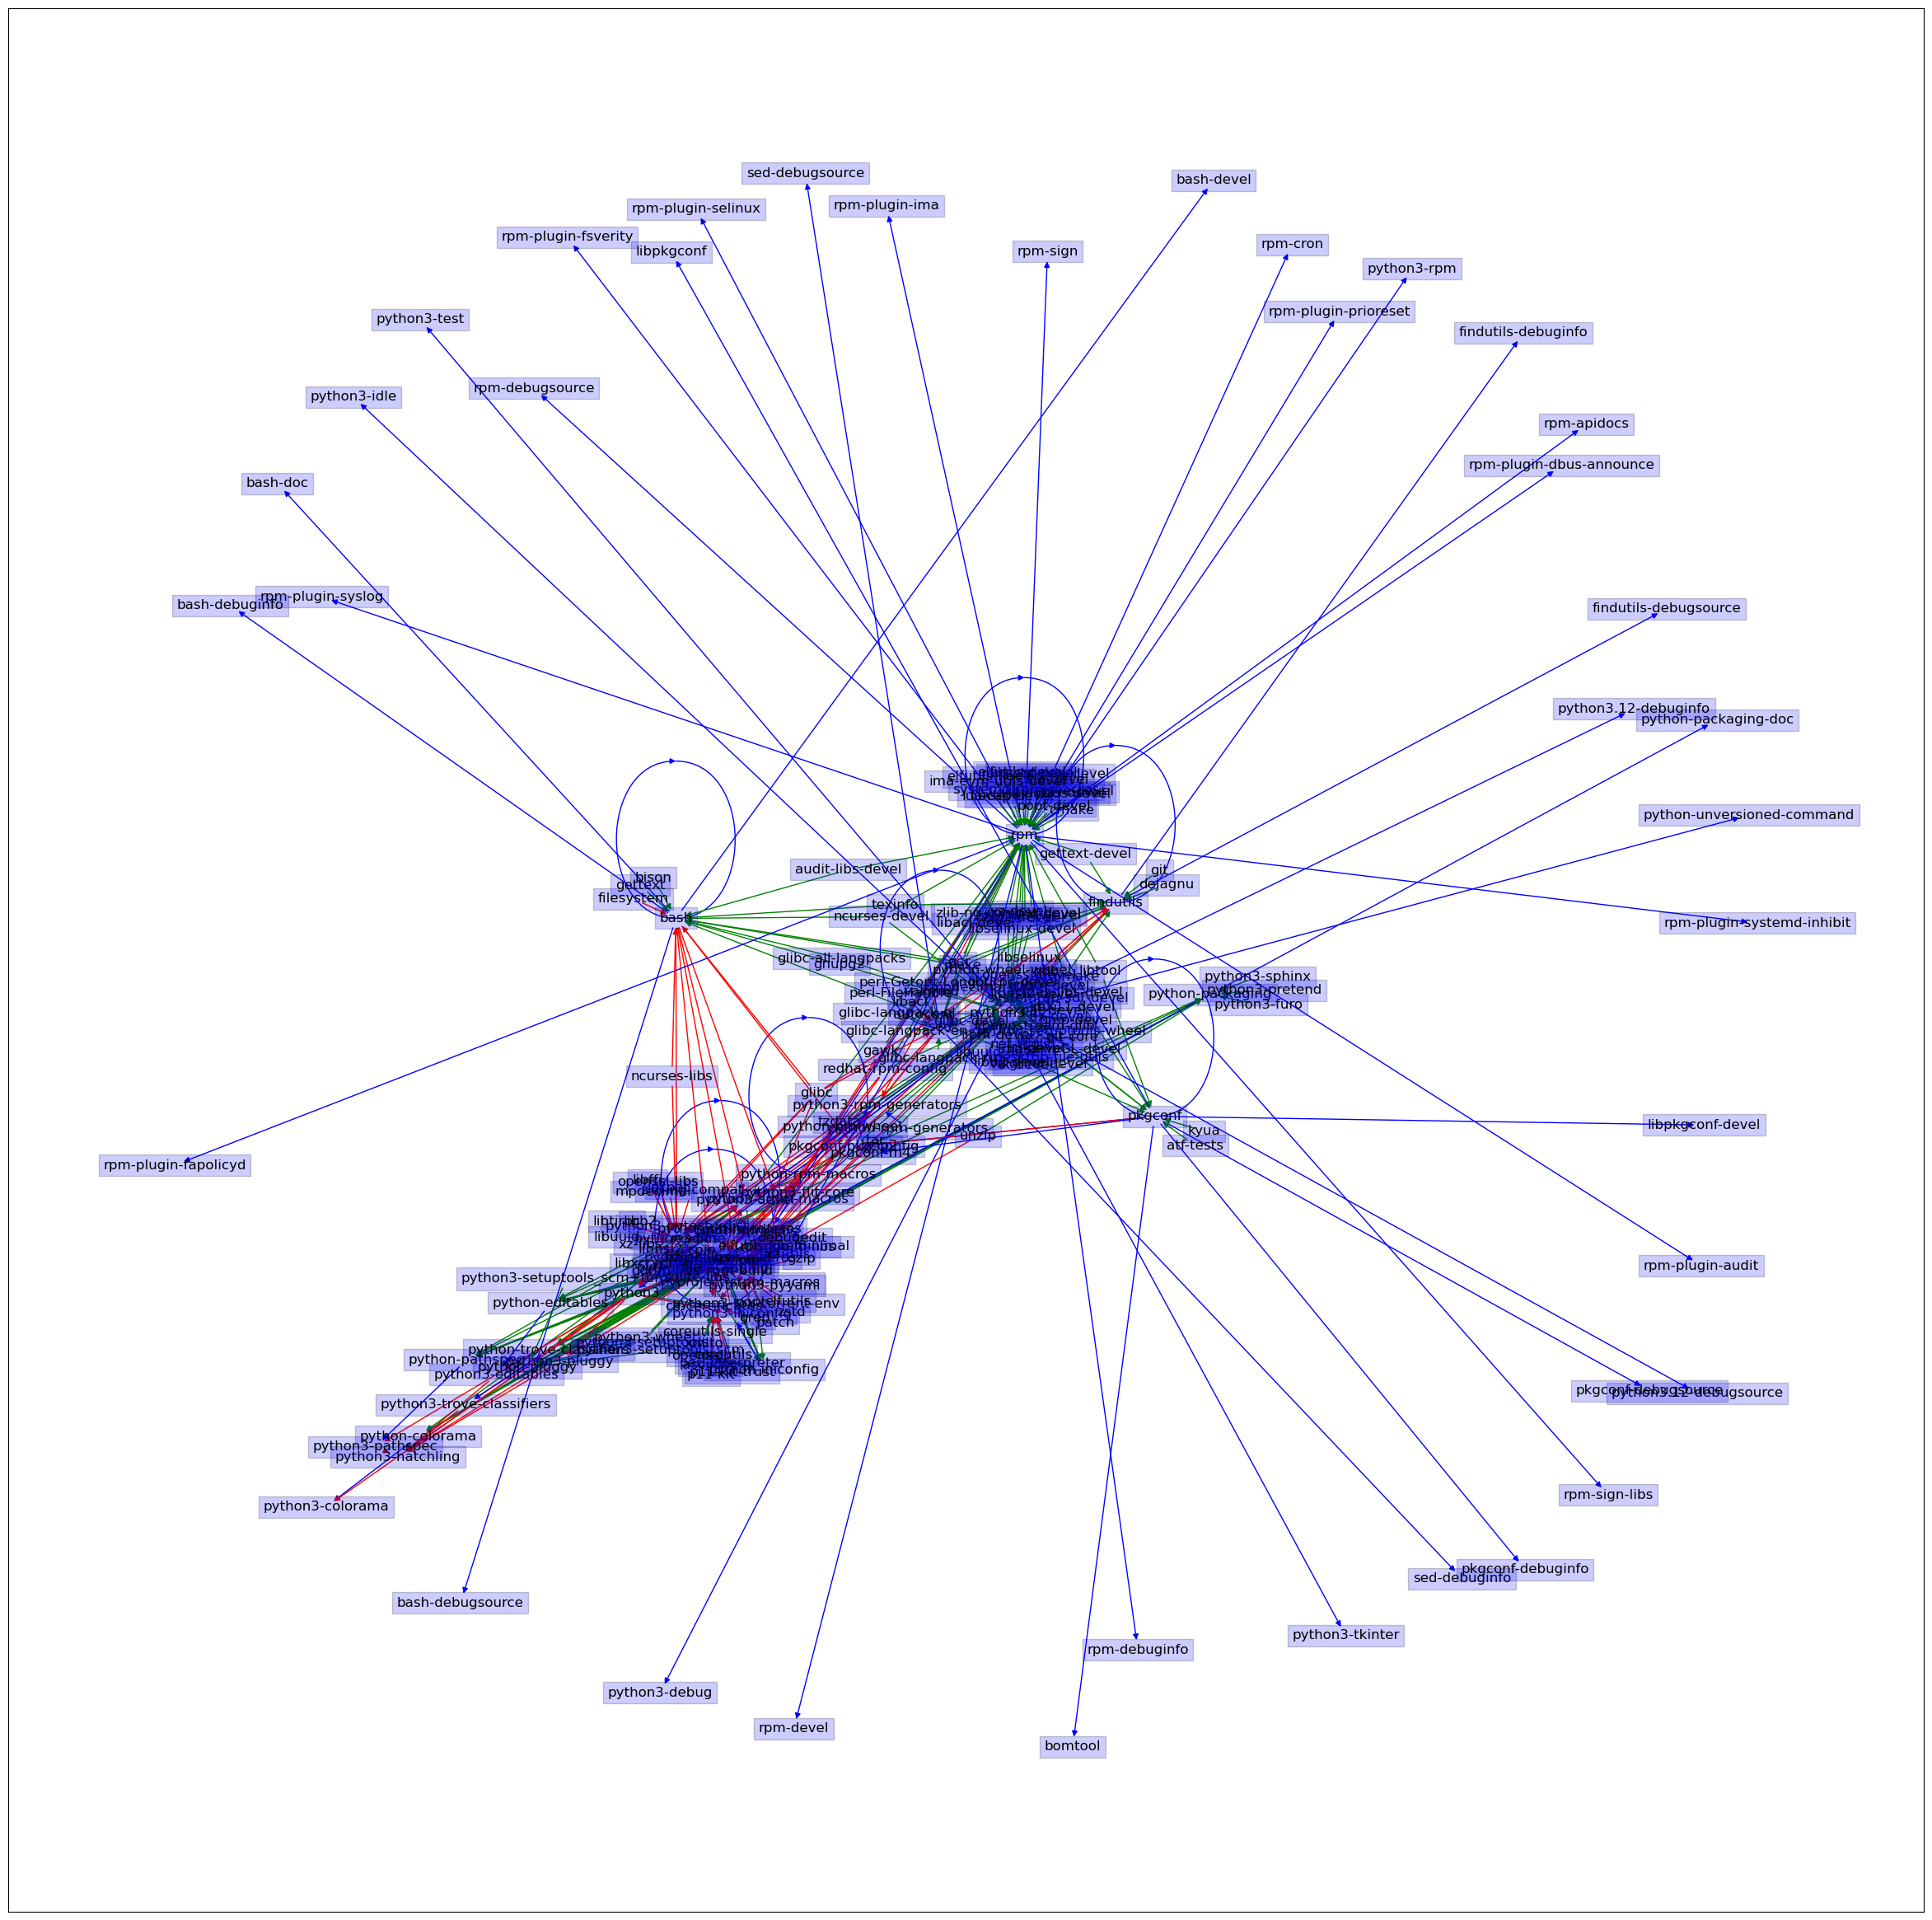

In [24]:
draw_graph(g)

In [25]:
a = nx.nx_agraph.to_agraph(g)

In [26]:
def draw_graphviz(g):
    svg = nx.nx_agraph.to_agraph(g).draw(prog='dot',format='svg')
    display(SVG(svg))

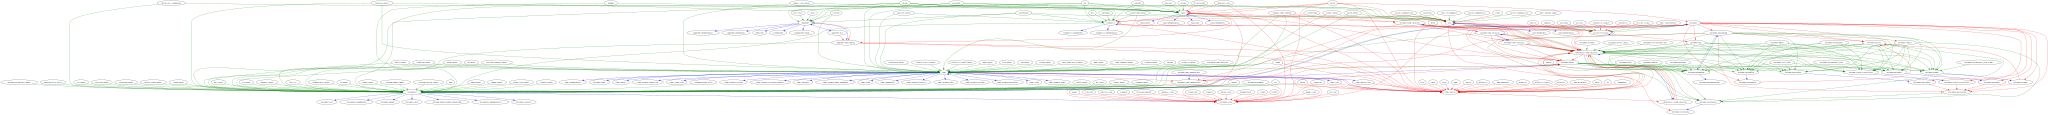

In [27]:
draw_graphviz(g)

# DNF API

In [29]:
import dnf

In [30]:
base = dnf.Base()

In [31]:
base.conf.read()

In [32]:
base.read_all_repos()

In [33]:
list(base.repos.iter_enabled())

[<Repo copr:copr.devel.redhat.com:lpol:qa-tools>,
 <Repo copr:copr.devel.redhat.com:petersen:rhel-repoquery>,
 <Repo copr:copr.fedorainfracloud.org:lbalhar:cronopete>,
 <Repo copr:copr.fedorainfracloud.org:phracek:PyCharm>,
 <Repo beaker-client>,
 <Repo Dropbox>,
 <Repo enpass>,
 <Repo fedora>,
 <Repo fedora-cisco-openh264>,
 <Repo updates>,
 <Repo rcm-tools-fedora-rpms>,
 <Repo rememberthemilk>,
 <Repo rpmfusion-free>,
 <Repo rpmfusion-free-updates>,
 <Repo rpmfusion-nonfree>,
 <Repo rpmfusion-nonfree-updates>,
 <Repo teamviewer>,
 <Repo virtualbox>,
 <Repo gitlab.com_paulcarroty_vscodium_repo>]

In [34]:
base.repos.get_matching("*").disable()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [35]:
base.repos.get_matching("rawhide").enable()

[None]

In [36]:
list(base.repos.iter_enabled())

[<Repo rawhide>]

In [37]:
base.repos.enable_source_repos()

In [38]:
base.repos.enable_debug_repos()

In [39]:
list(base.repos.iter_enabled())

[<Repo rawhide>, <Repo rawhide-debuginfo>, <Repo rawhide-source>]

In [40]:
base.fill_sack(load_system_repo=False)

In [41]:
q = base.sack.query().available()

In [42]:
q.run()[:5]

[<hawkey.Package object id 2, 0ad-0.0.26-21.fc41.x86_64, rawhide>,
 <hawkey.Package object id 3, 0ad-data-0.0.26-7.fc40.noarch, rawhide>,
 <hawkey.Package object id 4, 0xFFFF-0.10-7.fc40.x86_64, rawhide>,
 <hawkey.Package object id 5, 2048-cli-0.9.1-20.fc40.x86_64, rawhide>,
 <hawkey.Package object id 6, 2048-cli-nocurses-0.9.1-20.fc40.x86_64, rawhide>]

In [43]:
py312 = q.filter(name__eq="python3.12").run()[0]

In [44]:
def find_packages(string):
    return q.filter(name=string).run()

In [74]:
def resolve_SRPM(string):
    if res := q.filter(name=string).run():
        for pkg in res:
            if pkg.sourcerpm is None:
                return pkg

    raise RuntimeError(f"Cannot resolve SRPM for {string}")

In [77]:
def resolve(string):
    # Package name
    if res := q.filter(name=string).run():
        return res[0]

    # Provided by single package
    res = filter_duplicates(q.filter(provides=string).run())
    if len(res) == 1:
        return res.pop()

    # Transaction resolution
    base.install(string)
    base.resolve()
    for p in base.transaction.install_set:
        for pr in p.provides:
            if pr.name.startswith(string) or string in p.files:
                base.reset(goal=True)
                return p
    base.reset(goal=True)

    raise RuntimeError(f"Cannot resolve {string}")

In [46]:
resolve("python3-devel")

<hawkey.Package object id 42496, python3-devel-3.12.3-2.fc41.i686, rawhide>

In [47]:
resolve("python3dist(tldr)")

<hawkey.Package object id 72260, tldr-3.2.0-4.fc40.noarch, rawhide>

In [48]:
resolve("/usr/bin/pkg-config")

<hawkey.Package object id 39978, pkgconf-pkg-config-2.1.1-1.fc41.i686, rawhide>

In [49]:
resolve("/usr/bin/sh")

<hawkey.Package object id 2971, bash-5.2.26-3.fc40.x86_64, rawhide>

In [50]:
resolve("/usr/bin/gdb-add-index")

<hawkey.Package object id 9599, gdb-headless-14.2-7.fc41.x86_64, rawhide>

In [75]:
def SRPMs_for_RPMs(pkgs):
    return {resolve_SRPM(pkgname(p.sourcerpm)) for p in pkgs}

In [52]:
SRPMs_for_RPMs([resolve("python3-devel")])

{<hawkey.Package object id 127760, python3.12-3.12.3-2.fc41.src, rawhide-source>}

In [53]:
SRPMs_for_RPMs([resolve("python3-devel"), resolve("python3")])

{<hawkey.Package object id 127760, python3.12-3.12.3-2.fc41.src, rawhide-source>}

In [54]:
def filter_duplicates(s):
    included = set()
    res = set()
    for pkg in s:
        if pkg.name not in included:
            included.add(pkg.name)
            res.add(pkg)
    return res

In [55]:
def provides(pkg):
    res = set()
    for p in pkg.provides:
        res.add(resolve(p.name))
    return res

In [56]:
provides(py312)

{<hawkey.Package object id 41577, python-unversioned-command-3.12.3-2.fc41.noarch, rawhide>,
 <hawkey.Package object id 41611, python3-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 42480, python3-debug-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 42496, python3-devel-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 43186, python3-idle-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 43518, python3-libs-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 45446, python3-test-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 45497, python3-tkinter-3.12.3-2.fc41.i686, rawhide>,
 <hawkey.Package object id 102162, python3.12-debuginfo-3.12.3-2.fc41.x86_64, rawhide-debuginfo>,
 <hawkey.Package object id 102163, python3.12-debugsource-3.12.3-2.fc41.i686, rawhide-debuginfo>}

In [57]:
def requires(pkg):
    res = set()
    for p in pkg.requires:
        res.add(resolve(p.name))
    return filter_duplicates(res)

In [58]:
requires(py312)

{<hawkey.Package object id 2622, autoconf-2.72-2.fc41.noarch, rawhide>,
 <hawkey.Package object id 3345, bluez-libs-devel-5.76-1.fc41.i686, rawhide>,
 <hawkey.Package object id 3744, bzip2-1.0.8-18.fc40.x86_64, rawhide>,
 <hawkey.Package object id 3745, bzip2-devel-1.0.8-18.fc40.i686, rawhide>,
 <hawkey.Package object id 6127, desktop-file-utils-0.26-12.fc40.x86_64, rawhide>,
 <hawkey.Package object id 7508, expat-devel-2.6.2-1.fc41.i686, rawhide>,
 <hawkey.Package object id 8330, findutils-1:4.9.0-8.fc40.x86_64, rawhide>,
 <hawkey.Package object id 9466, gcc-c++-14.1.1-1.fc41.i686, rawhide>,
 <hawkey.Package object id 9595, gdb-14.2-7.fc41.x86_64, rawhide>,
 <hawkey.Package object id 9603, gdbm-devel-1:1.23-6.fc40.i686, rawhide>,
 <hawkey.Package object id 14364, git-core-2.45.1-1.fc41.x86_64, rawhide>,
 <hawkey.Package object id 14500, glibc-all-langpacks-2.39.9000-18.fc41.x86_64, rawhide>,
 <hawkey.Package object id 14503, glibc-devel-2.39.9000-18.fc41.i686, rawhide>,
 <hawkey.Packa

In [70]:
def create_graph(pkgname, depth=1):
    start = time.time()
    SRPM_done, RPM_done = set(), set()
    SRPM_queue, RPM_queue = set(), set()

    G = nx.MultiDiGraph()

    pkgs = find_packages(pkgname)

    for pkg in pkgs:
        if pkg.sourcerpm is None:
            SRPM_queue.add(pkg)
        else:
            RPM_queue.add(pkg)

    for round in range(depth):
        print(f"--- ROUND {round} ---")
        RPM_queue_next, SRPM_queue_next = set(), set()

        while len(SRPM_queue):
            SRPM = SRPM_queue.pop()
            SRPM_done.add(SRPM)
            print(f"SRPM - {SRPM.name}")
            rpms = provides(SRPM)
            for rpm in rpms:
                print(f"{SRPM.name} provides {rpm.name}")
                G.add_edge(SRPM.name, rpm.name, color="blue")
            RPM_queue_next |= (rpms - RPM_done)
            rpms = requires(SRPM)
            for rpm in rpms:
                print(f"{SRPM.name} BUILD requires {rpm.name}")
                G.add_edge(rpm.name, SRPM.name, color="green")
            RPM_queue_next |= (rpms - RPM_done)

        while len(RPM_queue):
            RPM = RPM_queue.pop()
            RPM_done.add(RPM)
            print(f"RPM - {RPM.name}")
            rpms = requires(RPM)
            for rpm in rpms:
                print(f"{RPM.name} requires {rpm.name}")
                G.add_edge(rpm.name, RPM.name, color="red")            
            RPM_queue_next |= (rpms - RPM_done)
            srpms = SRPMs_for_RPMs(rpms)
            SRPM_queue_next |= (srpms - SRPM_done)

        RPM_queue, SRPM_queue = RPM_queue_next, SRPM_queue_next

    print(f"Graph depth {depth} with {len(G.nodes)} nodes and {len(G.edges)} edges")
    end = time.time()
    print(f"Total seconds: {end - start}")
    return G

In [78]:
g = create_graph("python-colorama", depth=3)

--- ROUND 0 ---
SRPM - python-colorama
python-colorama provides python3-colorama
python-colorama BUILD requires python3-devel
python-colorama BUILD requires python3-tomli
python-colorama BUILD requires python3-pytest
python-colorama BUILD requires python3-hatchling
python-colorama BUILD requires python3-pip
python-colorama BUILD requires pyproject-rpm-macros
python-colorama BUILD requires python3-packaging
--- ROUND 1 ---
RPM - python3-devel
python3-devel requires python3-rpm-generators
python3-devel requires python3-rpm-macros
python3-devel requires pkgconf-pkg-config
python3-devel requires python3
python3-devel requires pyproject-rpm-macros
python3-devel requires bash
python3-devel requires python3-libs
python3-devel requires python-rpm-macros
RPM - python3-tomli
python3-tomli requires python3
RPM - python3-colorama
python3-colorama requires python3
RPM - python3-pytest
python3-pytest requires python3-packaging
python3-pytest requires python3
python3-pytest requires python3-pluggy
py

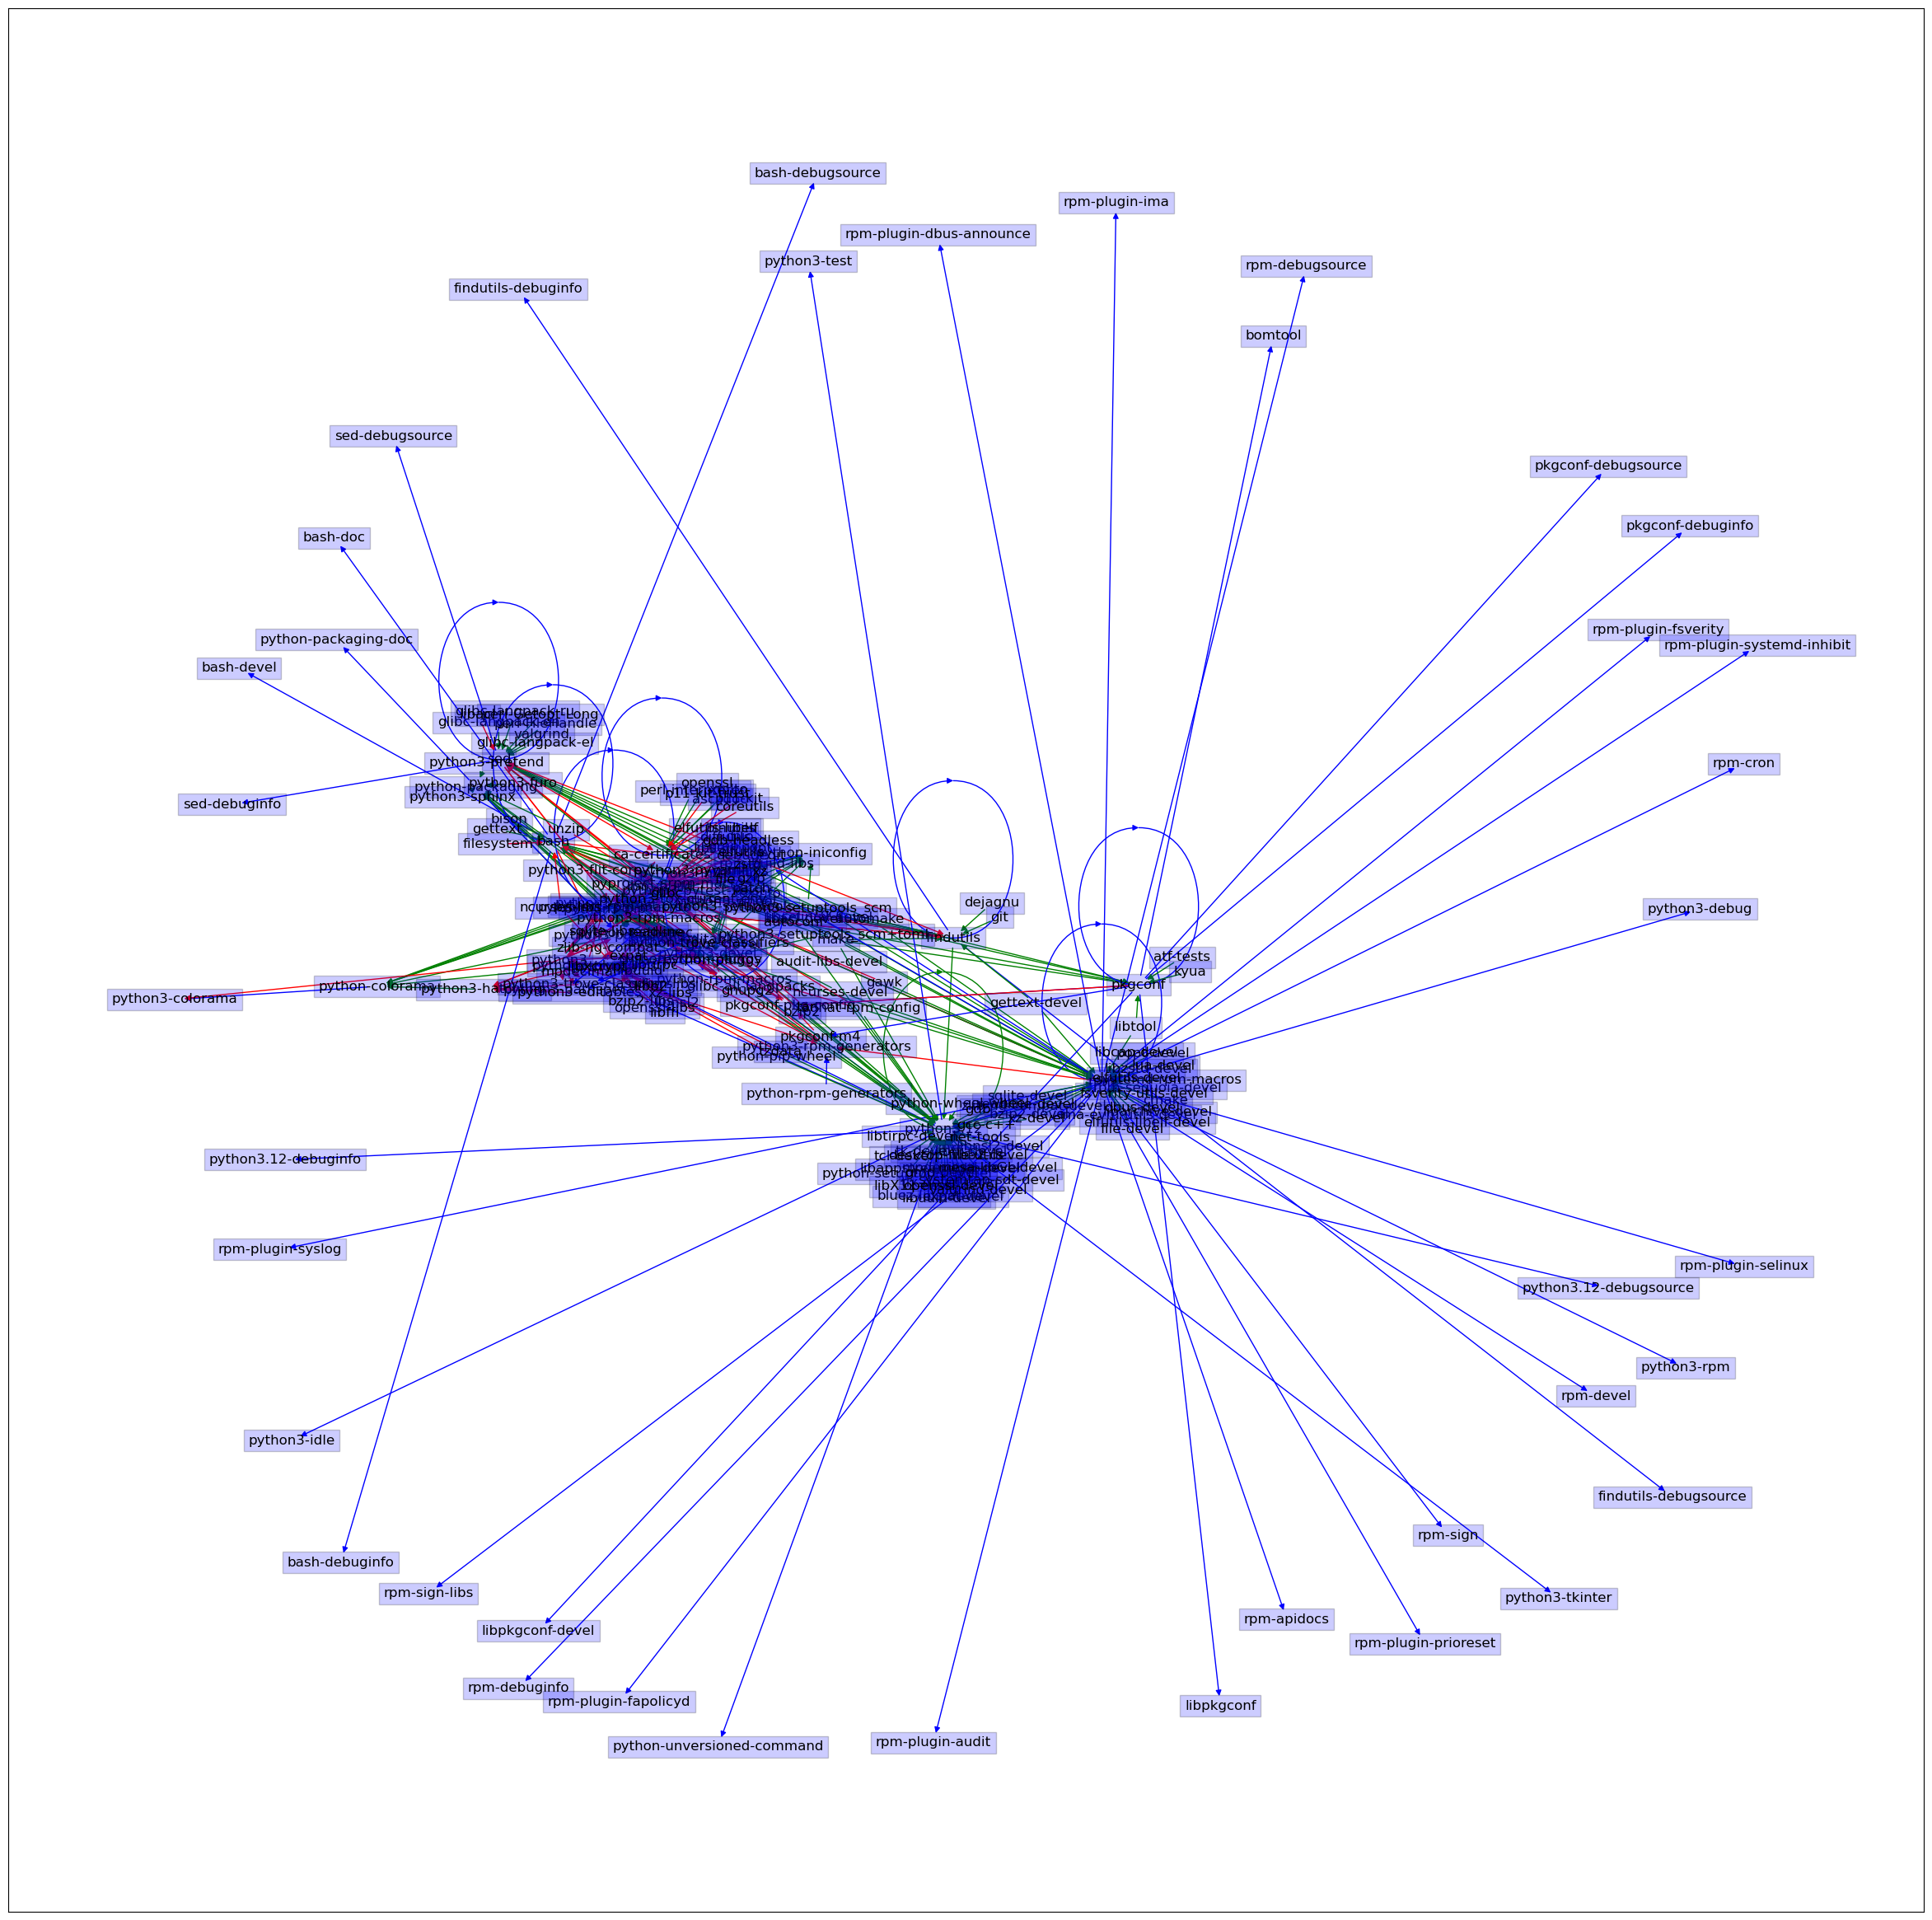

In [79]:
draw_graph(g)

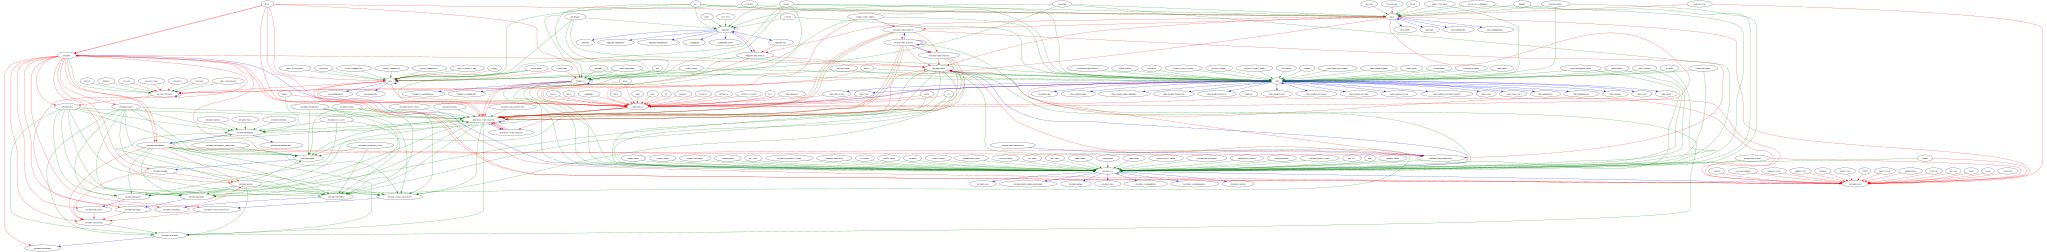

In [80]:
draw_graphviz(g)

In [81]:
set(g.nodes) - set(to_compare.nodes)

set()

In [82]:
set(to_compare.nodes) - set(g.nodes)

{'coreutils-single', 'gdb-minimal'}

In [83]:
len(to_compare.nodes), len(g.nodes)

(210, 208)

In [84]:
requires(resolve("rpm-build"))

{<hawkey.Package object id 2971, bash-5.2.26-3.fc40.x86_64, rawhide>,
 <hawkey.Package object id 3152, binutils-2.42.50-11.fc41.i686, rawhide>,
 <hawkey.Package object id 3744, bzip2-1.0.8-18.fc40.x86_64, rawhide>,
 <hawkey.Package object id 5305, cpio-2.15-1.fc40.x86_64, rawhide>,
 <hawkey.Package object id 5928, debugedit-5.0-16.fc41.x86_64, rawhide>,
 <hawkey.Package object id 6238, diffutils-3.10-5.fc40.x86_64, rawhide>,
 <hawkey.Package object id 7001, elfutils-0.191-7.fc41.x86_64, rawhide>,
 <hawkey.Package object id 7011, elfutils-libelf-0.191-7.fc41.x86_64, rawhide>,
 <hawkey.Package object id 8295, file-5.45-5.fc41.x86_64, rawhide>,
 <hawkey.Package object id 8330, findutils-1:4.9.0-8.fc40.x86_64, rawhide>,
 <hawkey.Package object id 9416, gawk-5.3.0-3.fc40.i686, rawhide>,
 <hawkey.Package object id 9599, gdb-headless-14.2-7.fc41.x86_64, rawhide>,
 <hawkey.Package object id 14498, glibc-2.39.9000-18.fc41.i686, rawhide>,
 <hawkey.Package object id 18192, grep-3.11-8.fc41.x86_64

In [85]:
requires(resolve("ca-certificates"))

{<hawkey.Package object id 2971, bash-5.2.26-3.fc40.x86_64, rawhide>,
 <hawkey.Package object id 5247, coreutils-9.5-1.fc41.x86_64, rawhide>,
 <hawkey.Package object id 18192, grep-3.11-8.fc41.x86_64, rawhide>,
 <hawkey.Package object id 34705, p11-kit-0.25.3-4.fc40.i686, rawhide>,
 <hawkey.Package object id 34710, p11-kit-trust-0.25.3-4.fc40.i686, rawhide>,
 <hawkey.Package object id 63313, sed-4.9-1.fc40.x86_64, rawhide>}